In [2]:
import warnings
warnings.filterwarnings('ignore') # to avoid warnings

import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys 

"""
Sklearn Libraries
"""
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

"""
Transformer Libraries
"""
from transformers import BertTokenizer,  AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup

"""
Pytorch Libraries
"""
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

sys.path.append('../')
from src.utilities.config_ import train_data_path
import src.utilities.utils as utils

In [26]:
# read csv
financial_data = pd.read_csv(os.path.join(train_data_path, "finance-dataset.csv"),
                             encoding='latin-1', 
                             names=['sentiment', 'NewsHeadline'])
financial_data

,sentiment,NewsHeadline
0,label,title
1,neutral,"According to Gran , the company has no plans t..."
2,neutral,Technopolis plans to develop in stages an area...
3,negative,The international electronic industry company ...
4,positive,With the new production plant the company woul...
...,...,...
4842,negative,LONDON MarketWatch -- Share prices ended lower...
4843,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4844,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4845,negative,Net sales of the Paper segment decreased to EU...


In [27]:
def show_headline_distribution(sequence_lengths, figsize = (15,8)):
    
    # Get the percentage of reviews with length > 512
    len_512_plus = [rev_len for rev_len in sequence_lengths if rev_len > 512]
    percent = (len(len_512_plus)/len(sequence_lengths))*100
    
    print("Maximum Sequence Length is {}".format(max(sequence_lengths)))
    
    # Configure the plot size
    plt.figure(figsize = figsize)

    sns.set(style='darkgrid')
    
    # Increase information on the figure
    sns.set(font_scale=1.3)
    
    # Plot the result
    sns.distplot(sequence_lengths, kde = False, rug = False)
    plt.title('Headlines Lengths Distribution')
    plt.xlabel('Headlines Length')
    plt.ylabel('Number of Headlines')

def show_random_headlines(total_number, df):
    
    # Get the random number of reviews
    n_reviews = df.sample(total_number)
    
    # Print each one of the reviews
    for val in list(n_reviews.index):
        print("Reviews #°{}".format(val))
        print(" - Sentiment: {}".format(df.iloc[val]["sentiment"]))
        print(" - News Headline: {}".format(df.iloc[val]["NewsHeadline"]))
        print("")
        
# Show 3 random headlines
show_random_headlines(5, financial_data)

Reviews #°786
 - Sentiment: positive
 - News Headline: The company estimates that the trend in demand for sports equipment will be steady in 2006 , '' Amer 's report said .

Reviews #°3297
 - Sentiment: neutral
 - News Headline: The new shares will provide the shareholders with full shareholder rights .

Reviews #°4747
 - Sentiment: negative
 - News Headline: Nokia shares hit 13.21 euros on Friday , down 50 percent from the start of the year in part because of the slow introduction of touch-screen models .

Reviews #°2846
 - Sentiment: neutral
 - News Headline: Cencorp would focus on the development , manufacture and marketing of standard products for production automation .

Reviews #°46
 - Sentiment: positive
 - News Headline: Sales increased due to growing market rates and increased operations .



Text(0, 0.5, 'Number of News')

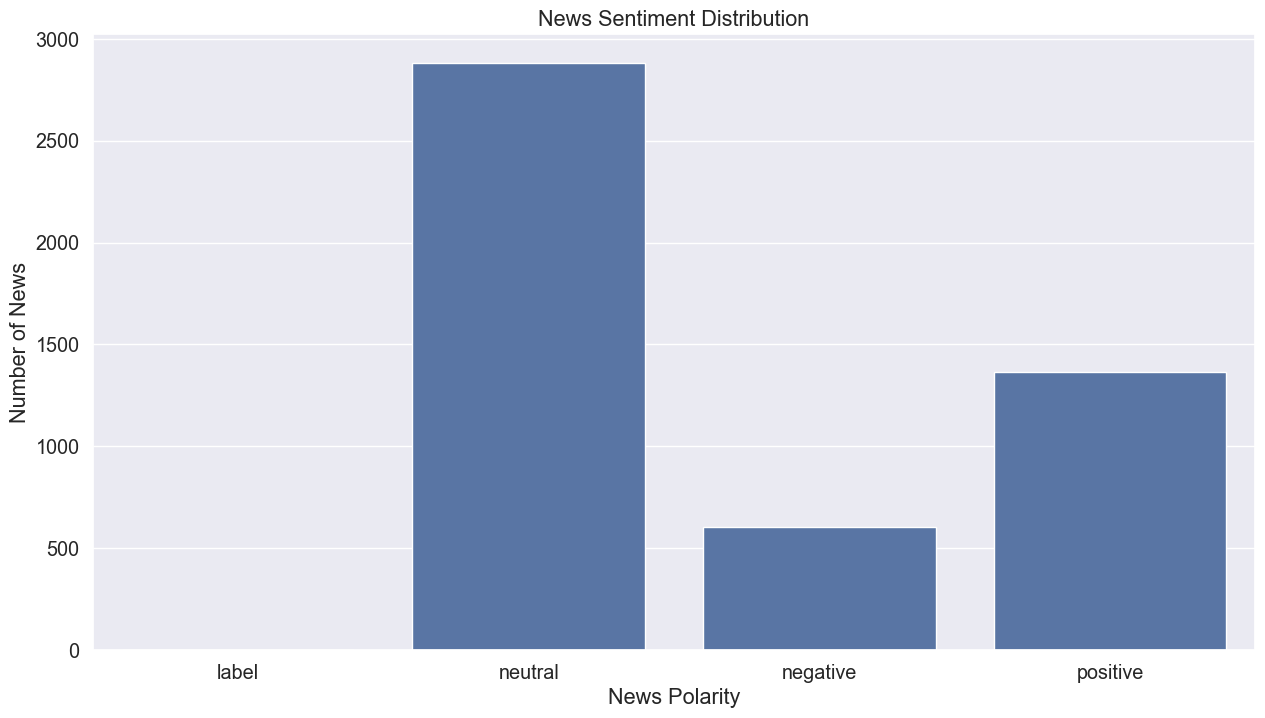

In [28]:
# Configure the plot size
plt.figure(figsize = (15,8))

sns.set(style='darkgrid')
    
# Increase information on the figure
sns.set(font_scale=1.3)
sns.countplot(x='sentiment', data = financial_data)
plt.title('News Sentiment Distribution')
plt.xlabel('News Polarity')
plt.ylabel('Number of News')

In [29]:
def get_headlines_len(df):
    
    headlines_sequence_lengths = []
    
    print("Encoding in progress...")
    for headline in tqdm(df.NewsHeadline):
        encoded_headline = finbert_tokenizer.encode(headline, 
                                         add_special_tokens = True)
        
        # record the length of the encoded review
        headlines_sequence_lengths.append(len(encoded_headline))
    print("End of Task.")
    
    return headlines_sequence_lengths

In [30]:
def encode_sentiments_values(df):
    
    possible_sentiments = df.sentiment.unique()
    sentiment_dict = {}
    
    for index, possible_sentiment in enumerate(possible_sentiments):
        sentiment_dict[possible_sentiment] = index
    
    # Encode all the sentiment values
    df['label'] = df.sentiment.replace(sentiment_dict)
    
    return df, sentiment_dict

In [33]:
# Encode the sentiment column
financial_data, sentiment_dict = encode_sentiments_values(financial_data)

financial_data = financial_data[1:]
financial_data

,sentiment,NewsHeadline,label
2,neutral,Technopolis plans to develop in stages an area...,0
3,negative,The international electronic industry company ...,1
4,positive,With the new production plant the company woul...,2
5,positive,According to the company 's updated strategy f...,2
6,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,2
...,...,...,...
4842,negative,LONDON MarketWatch -- Share prices ended lower...,1
4843,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,0
4844,negative,Operating profit fell to EUR 35.4 mn from EUR ...,1
4845,negative,Net sales of the Paper segment decreased to EU...,1


In [34]:
# Create training and validation data
X_train, X_val, y_train, y_val = train_test_split(financial_data.index.values, 
                                                  financial_data.label.values, 
                                                  test_size = 0.15, 
                                                  random_state = 2022, 
                                                  stratify = financial_data.label.values)

In [35]:
# Create the data type columns
financial_data.loc[X_train, 'data_type'] = 'train'
financial_data.loc[X_val, 'data_type'] = 'val'

# Vizualiez the number of sentiment occurence on each type of data
financial_data.groupby(['sentiment', 'label', 'data_type']).count()

NewsHeadline
sentiment label data_type              
negative  1     train               513
                val                  91
neutral   0     train              2446
                val                 432
positive  2     train              1159
                val                 204

In [36]:
# Get the FinBERT Tokenizer
finbert_tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert", 
                                          do_lower_case=True)

# Encode the Training and Validation Data
encoded_data_train = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data.data_type=='train'].NewsHeadline.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=150 # the maximum lenght observed in the headlines
)

encoded_data_val = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data.data_type=='val'].NewsHeadline.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=150 # the maximum lenght observed in the headlines
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(financial_data[financial_data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
sentiments_val = torch.tensor(financial_data[financial_data.data_type=='val'].label.values)


dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, sentiments_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [37]:
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
                                                          num_labels=len(sentiment_dict),
                                                          output_attentions=False,
                                                          output_hidden_states=False)

In [38]:
headlines_sequence_lengths = get_headlines_len(financial_data)

Encoding in progress...


100%|██████████| 4845/4845 [00:02<00:00, 2366.09it/s]

End of Task.


In [39]:
batch_size = 5

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [40]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [41]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in sentiment_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [42]:
seed_val = 2022
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_finBERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/3 [00:00<?, ?it/s]

: 